# Data Imports

In [1]:
import requests
import pandas as pd
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# Step 1: Get bootstrap data (teams, players)
bootstrap_url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
bootstrap_data = requests.get(bootstrap_url).json()

players_df = pd.DataFrame(bootstrap_data['elements'])
teams_df = pd.DataFrame(bootstrap_data['teams'])

# Step 2: Get all fixtures separately
fixtures_url = 'https://fantasy.premierleague.com/api/fixtures/'
all_fixtures = pd.DataFrame(requests.get(fixtures_url).json())

# Step 3: Get player histories with team context
all_player_histories = []

for player_id in players_df['id']:
    try:
        url = f'https://fantasy.premierleague.com/api/element-summary/{player_id}/'
        response = requests.get(url)
        player_data = response.json()
        
        # Get history
        history = pd.DataFrame(player_data['history'])
        if len(history) == 0:
            continue
            
        history['player_id'] = player_id
        all_player_histories.append(history)
        
        time.sleep(0.1)  # Be nice to the API
        
        # Print progress every 50 players
        if player_id % 50 == 0:
            print(f"Processed {player_id} players...")
        
    except Exception as e:
        print(f"Error with player {player_id}: {e}")
        continue

print(f"Finished collecting data for {len(all_player_histories)} players")

# Combine all histories
history_df = pd.concat(all_player_histories, ignore_index=True)

# IMPORTANT: Convert numeric columns to proper types
numeric_cols = ['total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
                'goals_conceded', 'saves', 'bonus', 'bps', 'yellow_cards', 'red_cards',
                'own_goals', 'penalties_saved', 'penalties_missed',
                'expected_goals', 'expected_assists', 'expected_goal_involvements',
                'expected_goals_conceded', 'influence', 'creativity', 'threat', 
                'ict_index', 'tackles', 'clearances_blocks_interceptions', 'recoveries',
                'selected', 'transfers_in', 'transfers_out', 'transfers_balance', 'value']

for col in numeric_cols:
    if col in history_df.columns:
        history_df[col] = pd.to_numeric(history_df[col], errors='coerce')

# Step 4: Add player info (name, team, position)
history_df = history_df.merge(
    players_df[['id', 'web_name', 'team', 'element_type', 'now_cost']], 
    left_on='player_id', 
    right_on='id',
    how='left'
)

# Step 4b: Add readable position names
# FPL position codes: 1=GK, 2=DEF, 3=MID, 4=FWD
position_map = {
    1: 'GK',
    2: 'DEF',
    3: 'MID',
    4: 'FWD'
}
history_df['position'] = history_df['element_type'].map(position_map)

# Step 5: Add player's team name and info
history_df = history_df.merge(
    teams_df[['id', 'name', 'short_name', 'strength', 'strength_overall_home', 
              'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
              'strength_defence_home', 'strength_defence_away']],
    left_on='team',
    right_on='id',
    how='left',
    suffixes=('', '_team_info')
)

# Step 6: Add opponent team info
history_df = history_df.merge(
    teams_df[['id', 'name', 'short_name', 'strength', 'strength_overall_home', 
              'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
              'strength_defence_home', 'strength_defence_away']],
    left_on='opponent_team',
    right_on='id',
    how='left',
    suffixes=('_player_team', '_opponent')
)

# Step 7: Calculate rolling stats (last 3, 5 gameweeks)
history_df = history_df.sort_values(['player_id', 'round'])

# Rolling points
history_df['points_last_3gw'] = history_df.groupby('player_id')['total_points'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
history_df['points_last_5gw'] = history_df.groupby('player_id')['total_points'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

# Rolling minutes (to predict playing time)
history_df['minutes_last_3gw'] = history_df.groupby('player_id')['minutes'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling goals
history_df['goals_last_3gw'] = history_df.groupby('player_id')['goals_scored'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling assists
history_df['assists_last_3gw'] = history_df.groupby('player_id')['assists'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xG (expected goals)
history_df['xg_last_3gw'] = history_df.groupby('player_id')['expected_goals'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xA (expected assists)
history_df['xa_last_3gw'] = history_df.groupby('player_id')['expected_assists'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xGI (expected goal involvements)
history_df['xgi_last_3gw'] = history_df.groupby('player_id')['expected_goal_involvements'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling clean sheets (for defenders/keepers)
history_df['clean_sheets_last_3gw'] = history_df.groupby('player_id')['clean_sheets'].transform(
    lambda x: x.rolling(window=3, min_periods=1).sum()
)

# Rolling bonus points
history_df['bonus_last_3gw'] = history_df.groupby('player_id')['bonus'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Step 8: Add team form (team's average points in last few games)
team_points_by_gw = history_df.groupby(['team', 'round'])['total_points'].sum().reset_index()
team_points_by_gw.columns = ['team', 'round', 'team_total_points']

team_points_by_gw = team_points_by_gw.sort_values(['team', 'round'])
team_points_by_gw['team_form_last_3gw'] = team_points_by_gw.groupby('team')['team_total_points'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Merge team form back
history_df = history_df.merge(
    team_points_by_gw[['team', 'round', 'team_form_last_3gw']],
    on=['team', 'round'],
    how='left'
)

# Step 9: Add fixture difficulty from opponent strength
history_df['fixture_difficulty'] = history_df.apply(
    lambda row: row['strength_defence_home_opponent'] if row['was_home'] 
    else row['strength_defence_away_opponent'],
    axis=1
)

# Step 10: Calculate performance metrics
# Goals vs expected goals (overperformance/underperformance)
history_df['goals_vs_xg'] = history_df['goals_scored'] - history_df['expected_goals']

# Assists vs expected assists
history_df['assists_vs_xa'] = history_df['assists'] - history_df['expected_assists']

# ICT index per 90 minutes (to normalize for playing time)
history_df['ict_per_90'] = history_df.apply(
    lambda row: (row['ict_index'] / row['minutes'] * 90) if row['minutes'] > 0 else 0,
    axis=1
)

# Step 11: Clean up column names
history_df = history_df.rename(columns={
    'web_name': 'player_name',
    'round': 'gameweek',
    'name_player_team': 'team_name',
    'short_name_player_team': 'team_short',
    'name_opponent': 'opponent_name',
    'short_name_opponent': 'opponent_short',
    'total_points': 'points'
})

# Step 12: Select comprehensive columns for your model
final_df = history_df[[
    # Identifiers
    'player_id', 'player_name', 'position', 'element_type', 'gameweek', 'fixture',
    
    # Match context
    'team_name', 'team_short', 'opponent_name', 'opponent_short', 'was_home',
    
    # Core performance stats (actual)
    'points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'bonus',
    'goals_conceded', 'saves', 'yellow_cards', 'red_cards',
    'own_goals', 'penalties_saved', 'penalties_missed',
    
    # Expected stats (underlying metrics)
    'expected_goals', 'expected_assists', 'expected_goal_involvements',
    'expected_goals_conceded',
    
    # Advanced metrics
    'influence', 'creativity', 'threat', 'ict_index',
    'bps',  # bonus point system
    'tackles', 'clearances_blocks_interceptions', 'recoveries',
    
    # Performance vs expectation
    'goals_vs_xg', 'assists_vs_xa', 'ict_per_90',
    
    # Rolling form (last 3 gameweeks)
    'points_last_3gw', 'points_last_5gw',
    'minutes_last_3gw', 
    'goals_last_3gw', 'assists_last_3gw',
    'xg_last_3gw', 'xa_last_3gw', 'xgi_last_3gw',
    'clean_sheets_last_3gw', 'bonus_last_3gw',
    
    # Team context
    'team_form_last_3gw',
    
    # Fixture difficulty
    'fixture_difficulty',
    'strength_overall_home_player_team', 'strength_overall_away_player_team',
    'strength_attack_home_player_team', 'strength_attack_away_player_team',
    'strength_defence_home_opponent', 'strength_defence_away_opponent',
    
    # Player info
    'now_cost',
    
    # Transfer data (popularity/ownership signals)
    'selected', 'transfers_in', 'transfers_out', 'transfers_balance'
]]

# Save it!
final_df.to_csv('fpl_enriched_history.csv', index=False)

Processed 700 players...
Processed 50 players...
Processed 200 players...
Processed 100 players...
Processed 150 players...
Processed 250 players...
Processed 300 players...
Processed 350 players...
Processed 400 players...
Processed 450 players...
Processed 500 players...
Processed 550 players...
Processed 600 players...
Processed 650 players...
Finished collecting data for 743 players

Total records: 5073

Position breakdown:
position
MID    2257
DEF    1677
GK      589
FWD     550
Name: count, dtype: int64

Sample of the data:
   player_id   player_name position  element_type  gameweek  fixture  \
0          1          Raya       GK             1         1        9   
1          1          Raya       GK             1         2       11   
2          1          Raya       GK             1         3       25   
3          1          Raya       GK             1         4       31   
4          1          Raya       GK             1         5       41   
5          1          Raya      

# Loading and Formatting data to prevent future peeking

In [2]:
# Load your enriched history data
df = pd.read_csv('fpl_enriched_history.csv')

# Print column names to debug
print("Available columns:")
print(df.columns.tolist())
print("\n")

# Sort by player and gameweek
df = df.sort_values(['player_id', 'gameweek'])

# ==============================================================
# TARGET: Predict points in CURRENT gameweek
# ==============================================================
df['target_points'] = df['points']

# ==============================================================
# FEATURES: Use LAGGED performance (past games)
# ==============================================================

# Lag individual gameweek stats (expanded list)
lag_features = ['points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
                'bonus', 'expected_goals', 'expected_assists', 
                'expected_goal_involvements', 'ict_index', 'bps',
                'influence', 'creativity', 'threat',  # Added ICT components
                'saves', 'goals_conceded',  # For goalkeepers/defenders
                'yellow_cards', 'red_cards']  # Disciplinary

for feature in lag_features:
    if feature in df.columns:
        df[f'{feature}_lag1'] = df.groupby('player_id')[feature].shift(1)

# ==============================================================
# Rolling averages (excluding current gameweek)
# ==============================================================

# Points
df['points_last_3gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['points_last_5gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df['points_last_10gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=10, min_periods=1).mean()
)

# Minutes
df['minutes_last_3gw'] = df.groupby('player_id')['minutes'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['minutes_last_5gw'] = df.groupby('player_id')['minutes'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Goals and Assists
df['goals_last_3gw'] = df.groupby('player_id')['goals_scored'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['assists_last_3gw'] = df.groupby('player_id')['assists'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['goals_last_5gw'] = df.groupby('player_id')['goals_scored'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df['assists_last_5gw'] = df.groupby('player_id')['assists'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Expected stats (xG, xA, xGI)
df['xg_last_3gw'] = df.groupby('player_id')['expected_goals'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['xa_last_3gw'] = df.groupby('player_id')['expected_assists'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['xgi_last_3gw'] = df.groupby('player_id')['expected_goal_involvements'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['xg_last_5gw'] = df.groupby('player_id')['expected_goals'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df['xa_last_5gw'] = df.groupby('player_id')['expected_assists'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# ICT components - CREATIVITY, INFLUENCE, THREAT
df['creativity_last_3gw'] = df.groupby('player_id')['creativity'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['influence_last_3gw'] = df.groupby('player_id')['influence'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['threat_last_3gw'] = df.groupby('player_id')['threat'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['creativity_last_5gw'] = df.groupby('player_id')['creativity'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df['influence_last_5gw'] = df.groupby('player_id')['influence'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df['threat_last_5gw'] = df.groupby('player_id')['threat'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# ICT Index
df['ict_last_3gw'] = df.groupby('player_id')['ict_index'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['ict_last_5gw'] = df.groupby('player_id')['ict_index'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# BPS (Bonus Point System)
df['bps_last_3gw'] = df.groupby('player_id')['bps'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['bps_last_5gw'] = df.groupby('player_id')['bps'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Clean sheets (for defenders/goalkeepers)
df['clean_sheets_last_3gw'] = df.groupby('player_id')['clean_sheets'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)

df['clean_sheets_last_5gw'] = df.groupby('player_id')['clean_sheets'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).sum()
)

# Bonus points
df['bonus_last_3gw'] = df.groupby('player_id')['bonus'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['bonus_last_5gw'] = df.groupby('player_id')['bonus'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Saves (for goalkeepers)
if 'saves' in df.columns:
    df['saves_last_3gw'] = df.groupby('player_id')['saves'].transform(
        lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
    )
    
    df['saves_last_5gw'] = df.groupby('player_id')['saves'].transform(
        lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
    )

# Goals conceded (for defenders/goalkeepers)
if 'goals_conceded' in df.columns:
    df['goals_conceded_last_3gw'] = df.groupby('player_id')['goals_conceded'].transform(
        lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
    )
    
    df['goals_conceded_last_5gw'] = df.groupby('player_id')['goals_conceded'].transform(
        lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
    )

# ==============================================================
# VOLATILITY & UPSIDE FEATURES (NEW!)
# ==============================================================

print("Creating volatility and upside features...")

# Max/Min points in recent windows
df['points_max_last_5gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).max()
)

df['points_min_last_5gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).min()
)

df['points_max_last_10gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=10, min_periods=1).max()
)

# Points range (volatility indicator)
df['points_range_last_5gw'] = df['points_max_last_5gw'] - df['points_min_last_5gw']

# Haul rate (% of games with 10+ points)
df['haul_rate_last_10gw'] = df.groupby('player_id')['points'].transform(
    lambda x: (x.shift(1).rolling(window=10, min_periods=1).apply(lambda y: (y >= 10).mean()))
)

# Had a haul recently? (binary indicator)
df['had_haul_last_3gw'] = df.groupby('player_id')['points'].transform(
    lambda x: (x.shift(1).rolling(window=3, min_periods=1).max() >= 10).astype(int)
)

df['had_haul_last_5gw'] = df.groupby('player_id')['points'].transform(
    lambda x: (x.shift(1).rolling(window=5, min_periods=1).max() >= 10).astype(int)
)

# Mega haul (15+ points)
df['mega_haul_rate_last_10gw'] = df.groupby('player_id')['points'].transform(
    lambda x: (x.shift(1).rolling(window=10, min_periods=1).apply(lambda y: (y >= 15).mean()))
)

# Games since last haul
def games_since_haul(points_series):
    """Count games since last 10+ point haul"""
    result = []
    games_since = 0
    for point in points_series:
        if point >= 10:
            games_since = 0
        else:
            games_since += 1
        result.append(games_since)
    return pd.Series(result, index=points_series.index)

df['games_since_haul'] = df.groupby('player_id')['points'].transform(
    lambda x: games_since_haul(x.shift(1))
)

# Home vs Away differential
# Calculate average points at home vs away
home_points = df.groupby(['player_id', 'was_home'])['points'].transform(
    lambda x: x.shift(1).expanding().mean()
)

df['home_points_avg'] = df.groupby('player_id').apply(
    lambda group: group[group['was_home'] == True]['points'].shift(1).expanding().mean()
).reset_index(level=0, drop=True)

df['away_points_avg'] = df.groupby('player_id').apply(
    lambda group: group[group['was_home'] == False]['points'].shift(1).expanding().mean()
).reset_index(level=0, drop=True)

df['home_vs_away_diff'] = df['home_points_avg'] - df['away_points_avg']
df['home_vs_away_diff'] = df['home_vs_away_diff'].fillna(0)

# Clean up temporary columns
df = df.drop(['home_points_avg', 'away_points_avg'], axis=1, errors='ignore')

# Fixture upside (threat combined with easy fixture)
df['fixture_upside'] = df.apply(
    lambda row: row['threat_last_3gw'] * (1 / (row['fixture_difficulty'] + 0.1)) 
    if pd.notna(row['threat_last_3gw']) and pd.notna(row['fixture_difficulty']) else 0,
    axis=1
)

# Attack upside (xG combined with easy fixture)
df['attack_upside'] = df.apply(
    lambda row: row['xg_last_3gw'] * (1 / (row['fixture_difficulty'] + 0.1)) 
    if pd.notna(row['xg_last_3gw']) and pd.notna(row['fixture_difficulty']) else 0,
    axis=1
)

# Creativity upside (creativity combined with easy fixture)
df['creativity_upside'] = df.apply(
    lambda row: row['creativity_last_3gw'] * (1 / (row['fixture_difficulty'] + 0.1)) 
    if pd.notna(row['creativity_last_3gw']) and pd.notna(row['fixture_difficulty']) else 0,
    axis=1
)

# Recent explosive performance (did player score 2+ goals or 2+ assists recently?)
if 'goals_scored' in df.columns:
    df['multi_goal_last_5gw'] = df.groupby('player_id')['goals_scored'].transform(
        lambda x: (x.shift(1).rolling(window=5, min_periods=1).max() >= 2).astype(int)
    )

if 'assists' in df.columns:
    df['multi_assist_last_5gw'] = df.groupby('player_id')['assists'].transform(
        lambda x: (x.shift(1).rolling(window=5, min_periods=1).max() >= 2).astype(int)
    )

# Points acceleration (is form accelerating upward?)
df['points_acceleration'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda y: np.polyfit(range(len(y)), y, 2)[0] if len(y) >= 2 else 0  # 2nd order polynomial
    )
)

# Consistency score (inverse of coefficient of variation)
df['consistency_score'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=3).apply(
        lambda y: 1 - (y.std() / (y.mean() + 0.1)) if y.mean() > 0 else 0
    )
)

print("Volatility features created!")

# ==============================================================
# Additional derived features (from before)
# ==============================================================

# Minutes played percentage
df['minutes_percentage_last_3'] = (df['minutes_last_3gw'] / 90) * 100
df['minutes_percentage_last_5'] = (df['minutes_last_5gw'] / 90) * 100

# Goals per 90 minutes
df['goals_per_90'] = df.apply(
    lambda row: (row['goals_last_3gw'] / row['minutes_last_3gw'] * 90) 
    if row['minutes_last_3gw'] > 0 else 0,
    axis=1
)

# Assists per 90 minutes
df['assists_per_90'] = df.apply(
    lambda row: (row['assists_last_3gw'] / row['minutes_last_3gw'] * 90) 
    if row['minutes_last_3gw'] > 0 else 0,
    axis=1
)

# xG per 90 minutes
df['xg_per_90'] = df.apply(
    lambda row: (row['xg_last_3gw'] / row['minutes_last_3gw'] * 90) 
    if row['minutes_last_3gw'] > 0 else 0,
    axis=1
)

# Creativity per 90 minutes
df['creativity_per_90'] = df.apply(
    lambda row: (row['creativity_last_3gw'] / row['minutes_last_3gw'] * 90) 
    if row['minutes_last_3gw'] > 0 else 0,
    axis=1
)

# Threat per 90 minutes
df['threat_per_90'] = df.apply(
    lambda row: (row['threat_last_3gw'] / row['minutes_last_3gw'] * 90) 
    if row['minutes_last_3gw'] > 0 else 0,
    axis=1
)

# ICT per 90 minutes
df['ict_per_90'] = df.apply(
    lambda row: (row['ict_last_3gw'] / row['minutes_last_3gw'] * 90) 
    if row['minutes_last_3gw'] > 0 else 0,
    axis=1
)

# Points consistency (standard deviation)
df['points_std_last_5gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=2).std()
)

# Points trend (slope)
df['points_trend'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) >= 2 else 0
    )
)

# Performance vs expectation
df['goals_vs_xg_last_3'] = df['goals_last_3gw'] - df['xg_last_3gw']
df['assists_vs_xa_last_3'] = df['assists_last_3gw'] - df['xa_last_3gw']

# ==============================================================
# Team form
# ==============================================================

# Check if team_name or team_short exists
if 'team_name' in df.columns:
    team_col = 'team_name'
elif 'team_short' in df.columns:
    team_col = 'team_short'
else:
    team_col = None
    print("Warning: No team column found. Skipping team form calculation.")

if team_col is not None:
    team_points_by_gw = df.groupby([team_col, 'gameweek'])['points'].sum().reset_index()
    team_points_by_gw.columns = [team_col, 'gameweek', 'team_total_points']
    team_points_by_gw = team_points_by_gw.sort_values([team_col, 'gameweek'])

    team_points_by_gw['team_form_last_3gw'] = team_points_by_gw.groupby(team_col)['team_total_points'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )

    df = df.merge(
        team_points_by_gw[[team_col, 'gameweek', 'team_form_last_3gw']],
        on=[team_col, 'gameweek'],
        how='left'
    )
else:
    df['team_form_last_3gw'] = 0

# ==============================================================
# Remove rows we can't use
# ==============================================================
df = df.dropna(subset=['points_last_3gw'])

# ==============================================================
# Select features for modeling
# ==============================================================

feature_columns = [
    # Player characteristics
    'position', 'now_cost',
    
    # Recent points form
    'points_last_3gw', 'points_last_5gw', 'points_last_10gw',
    'points_std_last_5gw',
    'points_trend',
    
    # Playing time
    'minutes_last_3gw', 'minutes_last_5gw',
    'minutes_percentage_last_3', 'minutes_percentage_last_5',
    
    # Goals and assists
    'goals_last_3gw', 'goals_last_5gw',
    'assists_last_3gw', 'assists_last_5gw',
    'goals_per_90', 'assists_per_90',
    
    # Expected stats
    'xg_last_3gw', 'xg_last_5gw',
    'xa_last_3gw', 'xa_last_5gw',
    'xgi_last_3gw',
    'xg_per_90',
    
    # Performance vs expectation
    'goals_vs_xg_last_3',
    'assists_vs_xa_last_3',
    
    # ICT components
    'creativity_last_3gw', 'creativity_last_5gw', 'creativity_per_90',
    'influence_last_3gw', 'influence_last_5gw',
    'threat_last_3gw', 'threat_last_5gw', 'threat_per_90',
    'ict_last_3gw', 'ict_last_5gw', 'ict_per_90',
    
    # Bonus points
    'bonus_last_3gw', 'bonus_last_5gw',
    'bps_last_3gw', 'bps_last_5gw',
    
    # Defensive stats
    'clean_sheets_last_3gw', 'clean_sheets_last_5gw',
    
    # VOLATILITY & UPSIDE FEATURES (NEW!)
    'points_max_last_5gw', 'points_min_last_5gw', 'points_max_last_10gw',
    'points_range_last_5gw',
    'haul_rate_last_10gw',
    'had_haul_last_3gw', 'had_haul_last_5gw',
    'mega_haul_rate_last_10gw',
    'games_since_haul',
    'home_vs_away_diff',
    'fixture_upside', 'attack_upside', 'creativity_upside',
    'multi_goal_last_5gw', 'multi_assist_last_5gw',
    'points_acceleration',
    'consistency_score',
    
    # Team context
    'team_form_last_3gw',
    
    # Current match context
    'was_home',
    'fixture_difficulty',
    
    # Team strength
    'strength_attack_home_player_team',
    'strength_attack_away_player_team',
    'strength_defence_home_opponent',
    'strength_defence_away_opponent',
    
    # Popularity
    'transfers_balance',
]

# Add conditional features if they exist
if 'goals_conceded_last_3gw' in df.columns:
    feature_columns.extend(['goals_conceded_last_3gw', 'goals_conceded_last_5gw'])
if 'saves_last_3gw' in df.columns:
    feature_columns.extend(['saves_last_3gw', 'saves_last_5gw'])

# Remove any features that don't exist in the dataframe
feature_columns = [col for col in feature_columns if col in df.columns]

target_column = 'target_points'

# Create final modeling dataset
model_df = df[feature_columns + [target_column] + ['player_id', 'player_name', 'gameweek']].copy()

# Handle any remaining NaNs
model_df = model_df.fillna(0)

# Replace any infinite values
model_df = model_df.replace([np.inf, -np.inf], 0)

# Save
model_df.to_csv('fpl_modeling_data_with_volatility.csv', index=False)

print(f"\n{'='*60}")
print("MODELING DATASET WITH VOLATILITY FEATURES CREATED")
print(f"{'='*60}")
print(f"\nTotal rows: {len(model_df)}")
print(f"Total features: {len(feature_columns)}")

print(f"\n{'='*60}")
print("NEW VOLATILITY FEATURES ADDED:")
print(f"{'='*60}")
volatility_features = [
    'points_max_last_5gw', 'points_min_last_5gw', 'points_max_last_10gw',
    'points_range_last_5gw', 'haul_rate_last_10gw', 'had_haul_last_3gw', 
    'had_haul_last_5gw', 'mega_haul_rate_last_10gw', 'games_since_haul',
    'home_vs_away_diff', 'fixture_upside', 'attack_upside', 'creativity_upside',
    'multi_goal_last_5gw', 'multi_assist_last_5gw', 'points_acceleration',
    'consistency_score'
]
for i, feat in enumerate(volatility_features, 1):
    if feat in feature_columns:
        print(f"{i}. {feat}")

print(f"\nData shape: {model_df.shape}")
print(f"\nSample data (first 5 rows):")
print(model_df.head())
print(f"\nTarget variable distribution:")
print(model_df['target_points'].describe())

Available columns:
['player_id', 'player_name', 'position', 'element_type', 'gameweek', 'fixture', 'team_name', 'team_short', 'opponent_name', 'opponent_short', 'was_home', 'points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'bonus', 'goals_conceded', 'saves', 'yellow_cards', 'red_cards', 'own_goals', 'penalties_saved', 'penalties_missed', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'influence', 'creativity', 'threat', 'ict_index', 'bps', 'tackles', 'clearances_blocks_interceptions', 'recoveries', 'goals_vs_xg', 'assists_vs_xa', 'ict_per_90', 'points_last_3gw', 'points_last_5gw', 'minutes_last_3gw', 'goals_last_3gw', 'assists_last_3gw', 'xg_last_3gw', 'xa_last_3gw', 'xgi_last_3gw', 'clean_sheets_last_3gw', 'bonus_last_3gw', 'team_form_last_3gw', 'fixture_difficulty', 'strength_overall_home_player_team', 'strength_overall_away_player_team', 'strength_attack_home_player_team', 'strength_attack_away_player_team', 'strength_def

C:\Users\Pisit Tangwongsiri\AppData\Local\Temp\ipykernel_21856\4173967407.py:242: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['home_points_avg'] = df.groupby('player_id').apply(
C:\Users\Pisit Tangwongsiri\AppData\Local\Temp\ipykernel_21856\4173967407.py:246: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['away_points_avg'] = df.groupby('player_id').apply(


Volatility features created!

MODELING DATASET WITH VOLATILITY FEATURES CREATED

Total rows: 4330
Total features: 70

NEW VOLATILITY FEATURES ADDED:
1. points_max_last_5gw
2. points_min_last_5gw
3. points_max_last_10gw
4. points_range_last_5gw
5. haul_rate_last_10gw
6. had_haul_last_3gw
7. had_haul_last_5gw
8. mega_haul_rate_last_10gw
9. games_since_haul
10. home_vs_away_diff
11. fixture_upside
12. attack_upside
13. creativity_upside
14. multi_goal_last_5gw
15. multi_assist_last_5gw
16. points_acceleration
17. consistency_score

Data shape: (4330, 74)

Sample data (first 5 rows):
  position  now_cost  points_last_3gw  points_last_5gw  points_last_10gw  \
1       GK        57        10.000000             10.0              10.0   
2       GK        57         8.000000              8.0               8.0   
3       GK        57         6.000000              6.0               6.0   
4       GK        57         4.666667              6.0               6.0   
5       GK        57         3.33

# Checking for Collinearity

VARIANCE INFLATION FACTOR (VIF) ANALYSIS
VIF > 10: High multicollinearity
VIF > 5: Moderate multicollinearity
VIF < 5: Low multicollinearity



c:\Users\Pisit Tangwongsiri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                          Feature          VIF
                     goals_scored          inf
                          assists          inf
                     transfers_in          inf
                transfers_balance          inf
                    transfers_out          inf
                 minutes_last_3gw          inf
                      goals_vs_xg          inf
                    assists_vs_xa          inf
                 expected_assists          inf
                   expected_goals          inf
        minutes_percentage_last_3          inf
                     xgi_last_3gw 3.516682e+06
                      xg_last_3gw 2.200646e+06
  expected_goal_involvements_lag1 1.258032e+06
              expected_goals_lag1 8.229557e+05
                      xa_last_3gw 5.481742e+05
       expected_goal_involvements 3.407506e+05
            expected_assists_lag1 2.332059e+05
strength_overall_home_player_team 6.092297e+03
                        ict_index 5.865052e+03
 strength_att

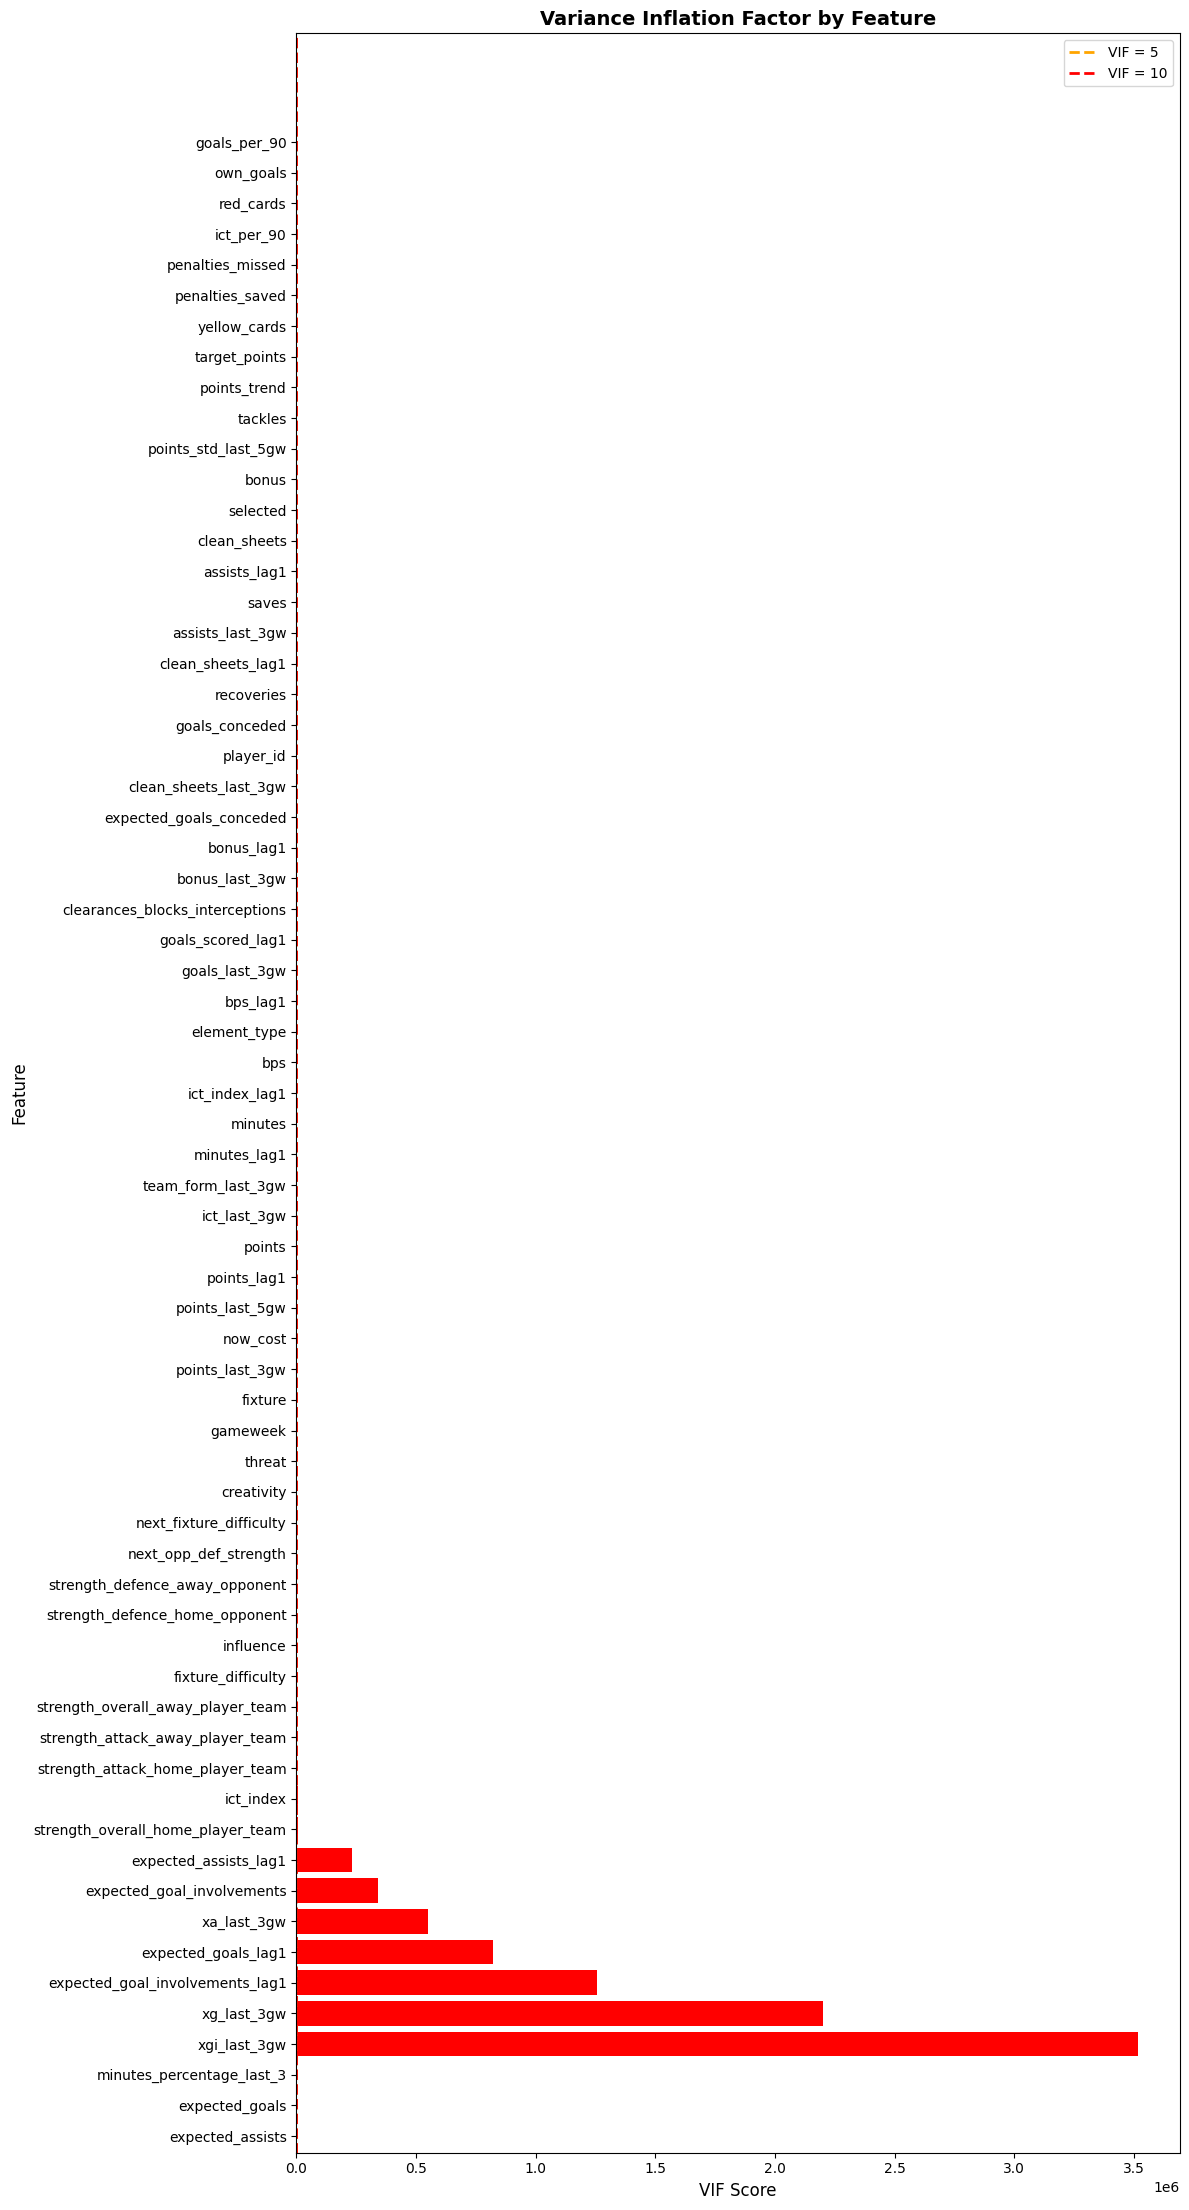


📊 VIF chart saved as 'vif_scores.png'

RECOMMENDATIONS

🔧 Features to consider removing (VIF > 10):
   - goals_scored
   - assists
   - transfers_in
   - transfers_balance
   - transfers_out
   - minutes_last_3gw
   - goals_vs_xg
   - assists_vs_xa
   - expected_assists
   - expected_goals
   - minutes_percentage_last_3
   - xgi_last_3gw
   - xg_last_3gw
   - expected_goal_involvements_lag1
   - expected_goals_lag1
   - xa_last_3gw
   - expected_goal_involvements
   - expected_assists_lag1
   - strength_overall_home_player_team
   - ict_index
   - strength_attack_home_player_team
   - strength_attack_away_player_team
   - strength_overall_away_player_team
   - fixture_difficulty
   - influence
   - strength_defence_home_opponent
   - strength_defence_away_opponent
   - next_opp_def_strength
   - next_fixture_difficulty
   - creativity
   - threat
   - gameweek
   - fixture
   - points_last_3gw
   - now_cost
   - points_last_5gw
   - points_lag1
   - points
   - ict_last_3gw
   - team_

In [5]:
def check_vif(df, feature_columns, save_plot=True):
    """
    Calculate Variance Inflation Factor (VIF) for all features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Your modeling dataframe
    feature_columns : list
        List of feature column names to check
    save_plot : bool
        Whether to save visualization (default True)
    
    Returns:
    --------
    pandas DataFrame : VIF scores for each feature
    """
    
    print("=" * 60)
    print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
    print("=" * 60)
    print("VIF > 10: High multicollinearity")
    print("VIF > 5: Moderate multicollinearity")
    print("VIF < 5: Low multicollinearity\n")
    
    # Prepare the data - only numeric features
    X = df[feature_columns].copy()
    
    # Handle categorical variables (one-hot encode if needed)
    if 'position' in X.columns:
        X = pd.get_dummies(X, columns=['position'], prefix='pos', drop_first=True)
    
    # Remove any remaining non-numeric columns
    X = X.select_dtypes(include=[np.number])
    
    # Replace inf values with NaN, then fill NaN with 0
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(X.shape[1])]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print(vif_data.to_string(index=False))
    
    # Flag problematic features
    high_vif = vif_data[vif_data['VIF'] > 10]
    if len(high_vif) > 0:
        print(f"\n⚠️  WARNING: {len(high_vif)} features with VIF > 10:")
        for idx, row in high_vif.iterrows():
            print(f"   - {row['Feature']}: {row['VIF']:.2f}")
    
    moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
    if len(moderate_vif) > 0:
        print(f"\n⚠️  CAUTION: {len(moderate_vif)} features with VIF 5-10:")
        for idx, row in moderate_vif.iterrows():
            print(f"   - {row['Feature']}: {row['VIF']:.2f}")
    
    if len(high_vif) == 0 and len(moderate_vif) == 0:
        print("\n✅ All features have VIF < 5 (low multicollinearity)")
    
    # Visualization
    if save_plot:
        plt.figure(figsize=(12, max(8, len(vif_data) * 0.3)))
        colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' 
                  for x in vif_data['VIF']]
        plt.barh(vif_data['Feature'], vif_data['VIF'], color=colors)
        plt.xlabel('VIF Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Variance Inflation Factor by Feature', fontsize=14, fontweight='bold')
        plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5')
        plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10')
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig('vif_scores.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n📊 VIF chart saved as 'vif_scores.png'")
    
    # Recommendations
    if len(high_vif) > 0:
        print("\n" + "=" * 60)
        print("RECOMMENDATIONS")
        print("=" * 60)
        print("\n🔧 Features to consider removing (VIF > 10):")
        for idx, row in high_vif.iterrows():
            print(f"   - {row['Feature']}")
        print("\n   Strategy options:")
        print("   1. Remove the feature with highest VIF")
        print("   2. Remove one from each highly correlated pair")
        print("   3. Combine correlated features into one")
        print("   4. Use regularization (Ridge/Lasso)")
        print("   5. Tree-based models handle multicollinearity well")
    
    return vif_data

vif_results = check_vif(df, df.columns)

# Exploration

## Affect of home games on points

<Axes: xlabel='was_home', ylabel='target_points'>

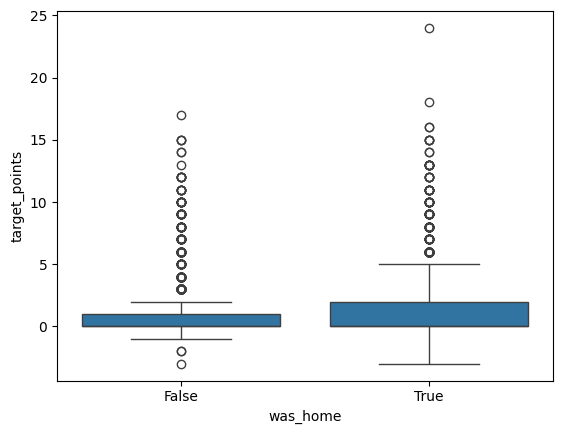

In [14]:
sns.boxplot(data=model_df,x='was_home',y='target_points')

It seems like there is some influence on the standard deviation of points gained based on whether the players play at home or not.

## Creativity Statistic

0.3569735678042031


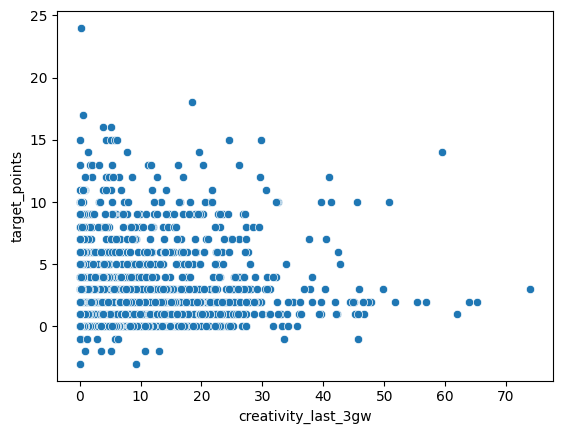

In [21]:
sns.scatterplot(data = model_df, x = 'creativity_last_3gw', y = 'target_points')
correlation = model_df['creativity_last_3gw'].corr(model_df['target_points'])
print(correlation)

There is a moderate correlation between the creativity statistic given by the premier league and points received.

## Affect of Team form

0.128408611571677


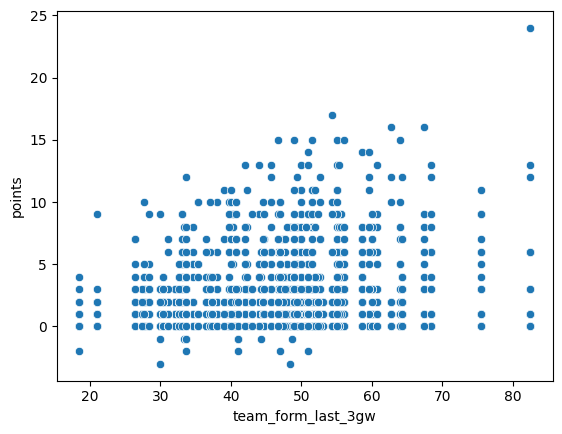

In [ ]:
sns.scatterplot(data=model_df,x='team_form_last_3gw',y='target_points')
correlation = model_df['team_form_last_3gw'].corr(model_df['target_points'])
print(correlation)

There is a small amount of correlation between team form and points received.

## Evaluating Crowd Knowledge

0.29261712656155553


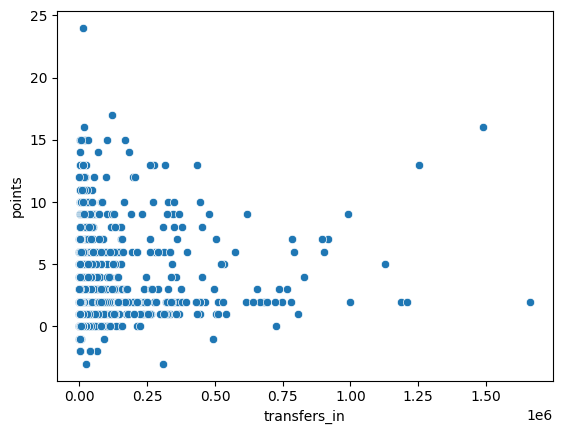

In [ ]:
sns.scatterplot(data=model_df,x='transfers_in',y='target_points')
correlation = model_df['transfers_in'].corr(model_df['target_points'])
print(correlation)

0.14204576183857992


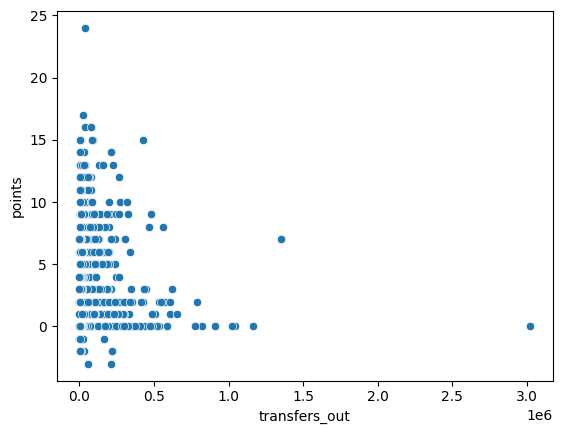

In [ ]:
sns.scatterplot(data=model_df,x='transfers_out',y='target_points')
correlation = model_df['transfers_out'].corr(model_df['target_points'])
print(correlation)

0.13650150290495414


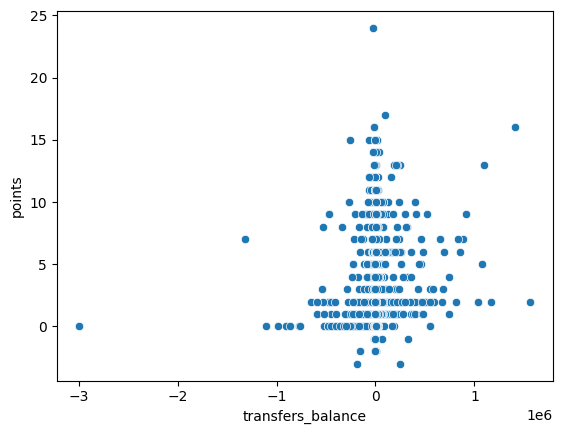

In [ ]:
sns.scatterplot(data=model_df,x='transfers_balance',y='target_points')
correlation = model_df['transfers_balance'].corr(model_df['target_points'])
print(correlation)

There is a moderate positive relationship between the players being transferred into clubs and the points that they receive. Transfers balance have less correlation.

# Modeling

In [8]:
def create_sample_weights(y):
    # This gives more weights to games with high points
    weights = np.ones(len(y))
    weights[y >= 10] = 3.0  # Triple weight for hauls (10+ points)
    weights[y >= 15] = 5.0  # 5x weight for mega hauls (15+ points)
    weights[y <= 2] = 0.5   # Less weight for blanks
    return weights

## Model for goalkeepers

In [48]:
goal_keeper_df = model_df[model_df['position'] == 'GK']
player_name = goal_keeper_df['player_name']
x = goal_keeper_df.drop(['position','target_points','player_id','gameweek'],axis=1)
y = goal_keeper_df['target_points']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=412)

train_names = x_train['player_name']
x_train = x_train.drop('player_name',axis=1)
x_train_scaled = StandardScaler().fit_transform(x_train)

test_names = x_test['player_name']
x_test = x_test.drop('player_name',axis=1)
x_test_scaled = StandardScaler().fit_transform(x_test)

In [49]:
gk_model = xgb.XGBRegressor(n_estimators = 200, max_depth = 2, learning_rate = 0.01, colsample_bytree= 0.1)
gk_model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [50]:
# Make predictions
y_pred = gk_model.predict(x_test)

# Calculate RMSE
rmse = root_mean_squared_error(y_test,y_pred)
print(f"RMSE: {rmse:.3f}")

RMSE: 0.917


### Fine tuning Model

In [36]:
# Define the parameter grid
param_grid = {
'max_depth': [2, 3, 5, 7],
'learning_rate': [0.005, 0.01, 0.05, 0.1],
'n_estimators': [100, 200, 300],
'colsample_bytree': [0.1,0.2 ,0.3, 0.7]
}

# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=412)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the model
grid_search.fit(x_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Best RMSE: 1.6014369264080637


### Saving Model

In [6]:
gk_model.save_model('gk_model.json')

## Defenders Model

In [12]:
def_df = model_df[model_df['position'] == 'DEF']
player_name = def_df['player_name']
x = def_df.drop(['position','target_points','player_id','gameweek'],axis=1)
y = def_df['target_points']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=412)

train_names = x_train['player_name']
x_train = x_train.drop('player_name',axis=1)
x_train_scaled = StandardScaler().fit_transform(x_train)

test_names = x_test['player_name']
x_test = x_test.drop('player_name',axis=1)
x_test_scaled = StandardScaler().fit_transform(x_test)

In [13]:
def_model = xgb.XGBRegressor(n_estimators = 300, max_depth = 4, learning_rate = 0.01, colsample_bytree= 0.15)
def_model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.15, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
# Make predictions
y_pred = def_model.predict(x_test)

# Calculate RMSE
rmse = root_mean_squared_error(y_test,y_pred)
print(f"RMSE: {rmse:.3f}")

RMSE: 2.319


### Fine Tuning Model

In [9]:
# Define the parameter grid
param_grid = {
'max_depth': [2, 3, 4],
'learning_rate': [0.005, 0.01, 0.02],
'n_estimators': [300, 400],
'colsample_bytree': [0.05, 0.1, 0.15]
}

# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=412)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the model
grid_search.fit(x_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'colsample_bytree': 0.15, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Best RMSE: 2.0846714554355437


## Midfielders Model

In [36]:
mid_df = model_df[model_df['position'] == 'MID']
player_name = mid_df['player_name']
x = mid_df.drop(['position','target_points','player_id','gameweek'],axis=1)
y = mid_df['target_points']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=412)

train_names = x_train['player_name']
x_train = x_train.drop('player_name',axis=1)
x_train_scaled = StandardScaler().fit_transform(x_train)

test_names = x_test['player_name']
x_test = x_test.drop('player_name',axis=1)
x_test_scaled = StandardScaler().fit_transform(x_test)

In [37]:
mid_model = xgb.XGBRegressor(n_estimators = 200, max_depth = 2, learning_rate = 0.02, colsample_bytree= 0.1)
mid_model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.1, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [38]:
# Make predictions
y_pred = mid_model.predict(x_test)

# Calculate RMSE
rmse = root_mean_squared_error(y_test,y_pred)
print(f"RMSE: {rmse:.3f}")

RMSE: 1.871


### Fine Tuning Model

In [6]:
# Define the parameter grid
param_grid = {
'quantile_alpha': [0.5,0.6,0.7,0.8],
'max_depth': [2,3,4,5,6,7],
'learning_rate': [0.005, 0.01, 0.02, 0.025],
'n_estimators': [200, 250, 300, 400],
'colsample_bytree': [0.05, 0.1, 0.15]
}

# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:quantileerror', random_state=412)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the model
grid_search.fit(x_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


KeyboardInterrupt: 

## Forward Model

In [18]:
fwd_df = model_df[model_df['position'] == 'MID']
player_name = fwd_df['player_name']
x = fwd_df.drop(['position','target_points','player_id','gameweek'],axis=1)
y = fwd_df['target_points']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=412)

train_names = x_train['player_name']
x_train = x_train.drop('player_name',axis=1)
x_train_scaled = StandardScaler().fit_transform(x_train)

test_names = x_test['player_name']
x_test = x_test.drop('player_name',axis=1)
x_test_scaled = StandardScaler().fit_transform(x_test)

sample_weights = create_sample_weights(y_train)
y_test = y_test.reset_index(drop=True)

In [32]:
pos_df = model_df[model_df['position'] == 'FWD'].copy()

train_df, test_df = train_test_split(
    pos_df, 
    test_size=0.2, 
    random_state=412,
    shuffle=False  # Important! Keep time order for FPL data
)

# Now extract X and y from each
feature_cols = [col for col in model_df.columns 
                if col not in ['target_points', 'player_id', 'player_name', 
                               'gameweek', 'position']]

x_train = train_df[feature_cols]
y_train = train_df['target_points']

x_test = test_df[feature_cols]
y_test = test_df['target_points']

test_df = test_df.reset_index(drop=True)  # Clean up index
sample_weights = create_sample_weights(y_train)

In [29]:
fwd_model = xgb.XGBRegressor(objective='reg:quantileerror',quantile_alpha = 0.5, n_estimators = 200, max_depth = 5, learning_rate = 0.01, colsample_bytree= 0.05, random_state = 412)
fwd_model.fit(x_train,y_train, sample_weight = sample_weights)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.05, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [30]:
# Make predictions
y_pred = fwd_model.predict(x_test)

# Calculate RMSE
rmse = root_mean_squared_error(y_test,y_pred)
print(f"RMSE: {rmse:.3f}")

RMSE: 2.135


### Fine Tuning Model

In [10]:
# Define the parameter grid
param_grid = {
'quantile_alpha': [0.5,0.6,0.7,0.8],
'max_depth': [4,5,6,7],
'learning_rate': [0.005, 0.01, 0.02],
'n_estimators': [200, 250, 300, 400],
'colsample_bytree': [0.05, 0.1, 0.15]
}

sample_weights = create_sample_weights(y_train)

# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:quantileerror', random_state=412)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the model
grid_search.fit(x_train, y_train, sample_weight = sample_weights)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best Parameters: {'colsample_bytree': 0.05, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'quantile_alpha': 0.5}
Best RMSE: 2.012023586645589


In [33]:
def train_boosted_ensemble(x_train, y_train):
    """
    Train multiple models and apply simple boosts
    """
    
    # Model 1: Quantile 0.65
    model1 = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=0.65,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    model1.fit(x_train, y_train)
    
    # Model 2: Quantile 0.75 with sample weights
    sample_weights = np.ones(len(y_train))
    sample_weights[y_train >= 10] = 5.0
    sample_weights[y_train >= 5] = 2.0
    
    model2 = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=0.75,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=7,
        random_state=43
    )
    model2.fit(x_train, y_train, sample_weight=sample_weights)
    
    # Model 3: Standard MSE with deeper trees
    model3 = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        min_child_weight=1,
        random_state=44
    )
    model3.fit(x_train, y_train, sample_weight=sample_weights)
    
    return [model1, model2, model3]

def predict_with_boost(models, x_test, test_df):
    """
    Ensemble prediction with simple situational boosts
    """
    # Get predictions from each model
    pred1 = models[0].predict(x_test)
    pred2 = models[1].predict(x_test)
    pred3 = models[2].predict(x_test)
    
    # Weighted average
    base_pred = 0.25 * pred1 + 0.35 * pred2 + 0.40 * pred3
    
    # Apply simple boosts based on features
    boosted_pred = base_pred.copy()
    
    # Boost 1: Easy fixtures
    easy_fixture = test_df['fixture_difficulty'].values <= 2
    boosted_pred[easy_fixture] *= 1.3  # 30% boost
    
    # Boost 2: Recent hauls
    had_haul = test_df['had_haul_last_3gw'].values == 1
    boosted_pred[had_haul] *= 1.2  # 20% boost
    
    # Boost 3: Home games
    is_home = test_df['was_home'].values == True
    boosted_pred[is_home] *= 1.1  # 10% boost
    
    # Boost 4: High threat players
    high_threat = test_df['threat_last_3gw'].values > test_df['threat_last_3gw'].quantile(0.75)
    boosted_pred[high_threat] *= 1.15  # 15% boost
    
    # Note: Boosts multiply (e.g., easy home fixture = 1.3 × 1.1 = 1.43x)
    return boosted_pred

# Usage
models = train_boosted_ensemble(x_train, y_train)
predictions = predict_with_boost(models, x_test, test_df)

print(f"Predicted mean: {predictions.mean():.2f}")
print(f"Predicted max: {predictions.max():.2f}")
print(f"% >= 5: {(predictions >= 5).mean()*100:.1f}%")
print(f"% >= 10: {(predictions >= 10).mean()*100:.1f}%")

Predicted mean: 2.01
Predicted max: 12.28
% >= 5: 12.8%
% >= 10: 3.2%
